In [1]:
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load img
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import statistics
import torchvision.models as models
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Setting device on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

torch.backends.cudnn.deterministic = True

Using device: cuda

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


#### Loading Datas

In [3]:
spacy_eng = spacy.load("en")

In [4]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [5]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=1):
        self.root_dir = root_dir

        self.df = pd.read_csv(captions_file, error_bad_lines=False, names=['image', 'caption'], header=None, sep='\t')
        self.transform = transform
        # Get img, caption columns
        self.df["image"] = self.df["image"].apply(lambda x: self.removeNumbers(x))
        self.imgs = self.df["image"]

        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def removeNumbers(self, image):
          image = image.split('#')[0]
          check = image.split('.')
          if len(check)>2:
            image = check[0]+"."+check[1]
          return image

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

In [6]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

In [7]:
def get_loader(
    root_folder,annotation_file,transform,batch_size=32,
    num_workers=8,shuffle=True,pin_memory=True,train_test_ratio=0.0, freq_threshold=1):
  
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform, freq_threshold=freq_threshold)

    dataset_train, dataset_test = torch.utils.data.random_split(dataset, 
                                  [int(len(dataset)*train_test_ratio), len(dataset)-int(len(dataset)*train_test_ratio)],
                                  generator=torch.Generator().manual_seed(42))

    pad_idx = dataset.vocab.stoi["<PAD>"]

    train_loader = DataLoader(
        dataset=dataset_train,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    test_loader = DataLoader(
        dataset=dataset_test,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    ) 

    return train_loader, dataset_train, test_loader, dataset_test, dataset

#### implementing Networks

In [8]:
class BahdanauAttention(nn.Module):
    """ Class performs Additive Bahdanau Attention.
    Source: https://arxiv.org/pdf/1409.0473.pdf
    """
    def __init__(self, num_features, hidden_dim, output_dim = 1):
        super(BahdanauAttention, self).__init__()
        self.num_features = num_features
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        # fully-connected layer to learn first weight matrix Wa
        self.W_a = nn.Linear(self.num_features, self.hidden_dim)
        # fully-connected layer to learn the second weight matrix Ua
        self.U_a = nn.Linear(self.hidden_dim, self.hidden_dim)
        # fully-connected layer to produce score (output), learning weight matrix va
        self.v_a = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, features, decoder_hidden):
        """
        Arguments:
        ----------
        - features - features returned from Encoder
        - decoder_hidden - hidden state output from Decoder
        Returns:
        ---------
        - context - context vector with a size of (1,2048)
        - atten_weight - probabilities, express the feature relevance
        """
        # add additional dimension to a hidden (need for summation later)
        decoder_hidden = decoder_hidden.unsqueeze(1)
        atten_1 = self.W_a(features)
        atten_2 = self.U_a(decoder_hidden)
        # apply tangent to combined result from 2 fc layers
        atten_tan = torch.tanh(atten_1+atten_2)
        # one score corresponds to one Encoder's output
        atten_score = self.v_a(atten_tan)
        atten_weight = F.softmax(atten_score, dim = 1)
        # first, we will multiply each vector by its softmax score
        # next, we will sum up this vectors, producing the attention context vector
        context = torch.sum(atten_weight * features,
                           dim = 1)
        atten_weight = atten_weight.squeeze(dim=2)
        return context, atten_weight


class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        
    def forward(self, images):
        features = self.resnet(images)
        batch, feature_maps, size_1, size_2 = features.size()       
        features = features.permute(0, 2, 3, 1)
        features = features.view(batch, size_1*size_2, feature_maps)
        
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, num_features):
        super(DecoderRNN, self).__init__()
        self.num_features = num_features
        self.embedding_dim = embed_size
        self.hidden_dim = hidden_size
        self.vocab_size = vocab_size
        self.sample_temp = 0.5

        self.embeddings = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTMCell(embed_size + num_features, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.attention = BahdanauAttention(num_features, hidden_size)
        self.drop = nn.Dropout(0.5)
        self.init_h = nn.Linear(num_features, hidden_size)
        self.init_c = nn.Linear(num_features, hidden_size)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, features, captions, sample_prob = 0.0):
        embed = self.embeddings(captions)
        h, c = self.init_hidden(features)
        seq_len = embed.size(1)
        feature_size = features.size(1)
        batch_size = embed.size(0)
        
        outputs = torch.zeros(batch_size, seq_len, self.vocab_size).to(device)
        atten_weights = torch.zeros(batch_size, seq_len, feature_size).to(device)
        
        for t in range(seq_len):
            sample_prob = 0.0 if t == 0 else 0.5
            use_sampling = np.random.random() < sample_prob
            if use_sampling == False:
                word_embed = embed[:,t,:]
            context, atten_weight = self.attention(features, h)
            # input_concat shape at time step t = (batch, embedding_dim + hidden_dim)
            input_concat = torch.cat([word_embed, context], 1)
            h, c = self.lstm(input_concat, (h,c))
            h = self.drop(h)
            output = self.fc(h)
            if use_sampling == True:
                # use sampling temperature to amplify the values before applying softmax
                scaled_output = output / self.sample_temp
                scoring = F.log_softmax(scaled_output, dim=1)
                top_idx = scoring.topk(1)[1]
                word_embed = self.embeddings(top_idx).squeeze(1)
            outputs[:, t, :] = output
            atten_weights[:, t, :] = atten_weight
            
        return outputs, atten_weights


    def init_hidden(self, features):
        mean_annotations = torch.mean(features, dim = 1)
        h0 = self.init_h(mean_annotations)
        c0 = self.init_c(mean_annotations)
        return h0, c0
    def greedy_search(self, features, vocabulary, max_sentence = 40):

        sentence = []
        weights = []
        input_word = torch.tensor([vocabulary.stoi['<SOS>']]).to(device)
        h, c = self.init_hidden(features)
        while True:
            embedded_word = self.embeddings(input_word)
            context, atten_weight = self.attention(features, h)
            # input_concat shape at time step t = (batch, embedding_dim + context size)
            input_concat = torch.cat([embedded_word, context],  dim = 1)
            h, c = self.lstm(input_concat, (h,c))
            h = self.drop(h)
            output = self.fc(h)
            scoring = F.log_softmax(output, dim=1)
            top_idx = scoring[0].topk(1)[1]
            sentence.append(top_idx.item())
            weights.append(atten_weight)
            input_word = torch.tensor(top_idx)
            if (len(sentence) >= max_sentence or top_idx == vocabulary.stoi['<EOS>']):
                break
        return sentence, weights


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, num_features):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers, num_features)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs, _ = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=40):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image)
            sentence, weights = self.decoderRNN.greedy_search(x, vocabulary, max_sentence = max_length)

        return [vocabulary.itos[idx] for idx in sentence], weights


    def init_hidden(self, features):
        mean_annotations = torch.mean(features, dim = 1)
        h0 = self.init_h(mean_annotations)
        c0 = self.init_c(mean_annotations)
        return h0, c0



#### Training

In [12]:
model_save_dir = "/content/drive/My Drive/Courses/DeepLearning/HW03/Q03/attention_model.pth.tar"


def save_checkpoint(state, filename=model_save_dir):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])


torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
save_model = True
train_CNN = False


# Hyperparameters
batch_size = 64
embed_size = 300
hidden_size = 256
num_features = 2048
num_layers = 1
learning_rate = 1e-4
momentum = 0.9
num_epochs = 100



transform = transforms.Compose([ 
    transforms.Resize((224, 224)),                          
    # transforms.RandomCrop(224),                     
    # transforms.RandomHorizontalFlip(),               
    transforms.ToTensor(),                           
    transforms.Normalize((0.5, 0.5, 0.5),      
                         (0.5, 0.5, 0.5))])

train_loader, dataset_train, test_loader, dataset_test, dataset = get_loader(
    root_folder="/content/drive/My Drive/Courses/DeepLearning/HW03/Q03/Datas/Flicker8k_Dataset",
    annotation_file="/content/drive/My Drive/Courses/DeepLearning/HW03/Q03/Datas/Flickr8k.token.txt",
    transform=transform,
    num_workers=2,
    batch_size=batch_size,
    train_test_ratio=0.9,
    freq_threshold = 4
)
vocab_size = len(dataset.vocab)


# initialize model, loss etc
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers, num_features).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"]).to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [10]:
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip
!unzip glove.42B.300d.zip
!rm glove.42B.300d.zip

--2022-01-11 10:50:06--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2022-01-11 10:50:06--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2022-01-11 10:50:07--  http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Sav

In [11]:
def load_embeddings(filename):
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in tqdm(enumerate(infile)):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

embeddings = load_embeddings('glove.42B.300d.txt')
embeddings.shape

1917494it [03:31, 9048.77it/s]


(1917494, 300)

In [15]:
vectors = torch.randn(len(dataset.vocab), embed_size)
ixx = 0
for i in range(10,len(dataset.vocab)):
        try:
            vectors[i,:] = torch.FloatTensor(embeddings.loc[dataset.vocab.itos[i]].to_numpy())
        except:
            ixx =ixx+1
print(vectors.shape, ixx)

model.decoderRNN.embeddings.weight.data.copy_(vectors)
model.decoderRNN.embeddings.weight.requires_grad = False

torch.Size([3432, 300]) 4


In [16]:
def write_log(file_path, stat):
  with open(file_path, 'a') as the_file:
    the_file.write(stat+"\n")

In [17]:
def plot_examples(imgs):

  print("\n")
  img2plot = imgs[0].cpu().permute(1,2,0)-torch.min(imgs[0].cpu().permute(1,2,0))
  img2plot = img2plot/torch.max(img2plot)
  # plt.imshow(img2plot)
  # plt.show()
  with torch.no_grad():
    predicted_caption, weights = model.caption_image(imgs[0].unsqueeze(0), dataset.vocab)
  try:
    visualize_attention(img2plot, predicted_caption, weights)
  except:
    print("\n"+" ".join(predicted_caption))
  # print("\n")


def visualize_attention(orig_image, words, atten_weights):
    fig = plt.figure(figsize=(20,15)) 
    len_tokens = len(words)
    
    for i in range(len(words)):
        atten_current = atten_weights[i].detach().cpu().numpy()
        atten_current = atten_current.reshape(7,7)       
        ax = fig.add_subplot(len_tokens//2, len_tokens//2, i+1)
        ax.set_title(words[i])
        img = ax.imshow(np.squeeze(orig_image))
        ax.imshow(atten_current, cmap='gray', alpha=0.8, extent=img.get_extent(), interpolation = 'bicubic')
    plt.tight_layout()
    plt.show()

In [18]:
def validation():
  
  Loss = 0
  Acc = 0
  with torch.no_grad():
    for idx, (imgs, captions) in enumerate(test_loader):
        imgs = imgs.to(device)
        captions = captions.to(device)
        captions = captions.permute(1,0)
        
        outputs = model(imgs, captions)

        loss = criterion(outputs.view(-1, vocab_size), captions.reshape(-1))
        acc = torch.sum(outputs.topk(1)[1].reshape(-1) == captions.reshape(-1))/ captions.reshape(-1).shape[0]
        Acc = Acc+acc
        Loss = Loss+loss.item()

  Acc = Acc/(idx+1)
  Loss = Loss/(idx+1)
  return Loss, Acc

In [19]:
def train(print_every):

    if load_model:
      load_checkpoint(torch.load(model_save_dir), model, optimizer)
    
    for epoch in range(num_epochs):

        step = 0

        if save_model:
          checkpoint = {
              "state_dict": model.state_dict(),
              "optimizer": optimizer.state_dict(),
              "step": step,}
          save_checkpoint(checkpoint)
        num_itters = len(train_loader)
        for idx, (imgs, captions) in enumerate(train_loader):

            imgs = imgs.to(device)
            captions = captions.to(device)
            captions = captions.permute(1,0)
            outputs = model(imgs, captions)

            loss = criterion(outputs.view(-1, vocab_size), captions.reshape(-1))
            acc = torch.sum(outputs.topk(1)[1].reshape(-1) == captions.reshape(-1))/ captions.reshape(-1).shape[0]
            
            if step % print_every == 0:
              loss_val, acc_val = validation()
              stats = '{2}/{3} - {0}/{1} |  Loss train-val = {4:.4f} - {6:.4f} | Acc train - val = {5:.4f} - {7:.4f}'.format(
                    idx, num_itters, epoch, num_epochs, loss.item(), acc, loss_val, acc_val)
              print('\r' + stats)
              write_log("/content/drive/My Drive/Courses/DeepLearning/HW03/Q03/Logs_attention.txt", stats)

            step += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        plot_examples(imgs)


=> Saving checkpoint
0/100 - 0/569 |  Loss train-val = 8.1783 - 8.1804 | Acc train - val = 0.0000 - 0.0001
0/100 - 200/569 |  Loss train-val = 4.6026 - 4.6254 | Acc train - val = 0.1658 - 0.1510
0/100 - 400/569 |  Loss train-val = 4.5051 - 4.3471 | Acc train - val = 0.1462 - 0.1712




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


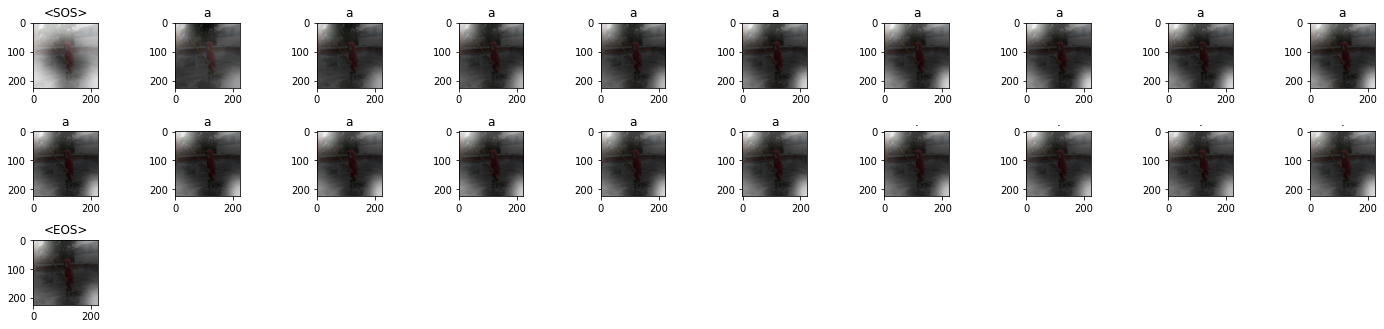

=> Saving checkpoint
1/100 - 0/569 |  Loss train-val = 4.0634 - 4.1910 | Acc train - val = 0.2434 - 0.1867
1/100 - 200/569 |  Loss train-val = 4.3200 - 4.0825 | Acc train - val = 0.2046 - 0.1886
1/100 - 400/569 |  Loss train-val = 4.1699 - 3.9808 | Acc train - val = 0.1974 - 0.1973




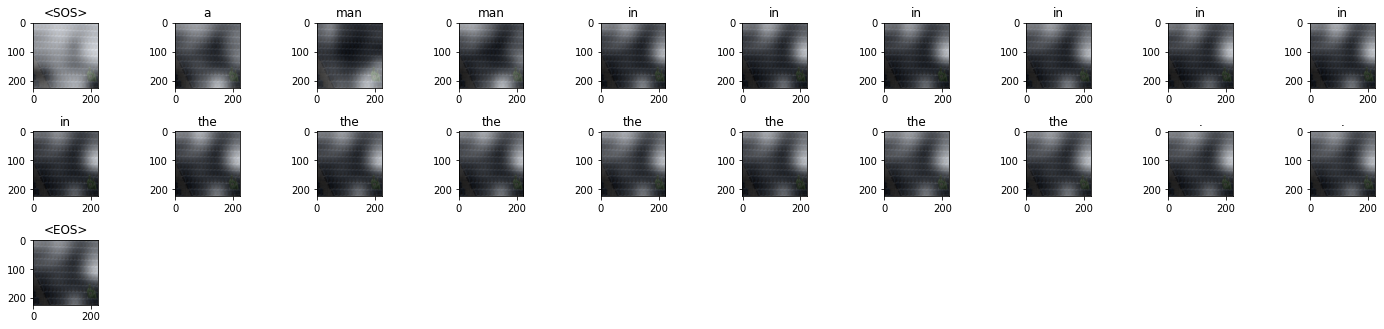

=> Saving checkpoint
2/100 - 0/569 |  Loss train-val = 3.8137 - 3.8674 | Acc train - val = 0.1792 - 0.2041
2/100 - 200/569 |  Loss train-val = 3.6627 - 3.8281 | Acc train - val = 0.2199 - 0.2073
2/100 - 400/569 |  Loss train-val = 3.9347 - 3.7458 | Acc train - val = 0.1953 - 0.2133




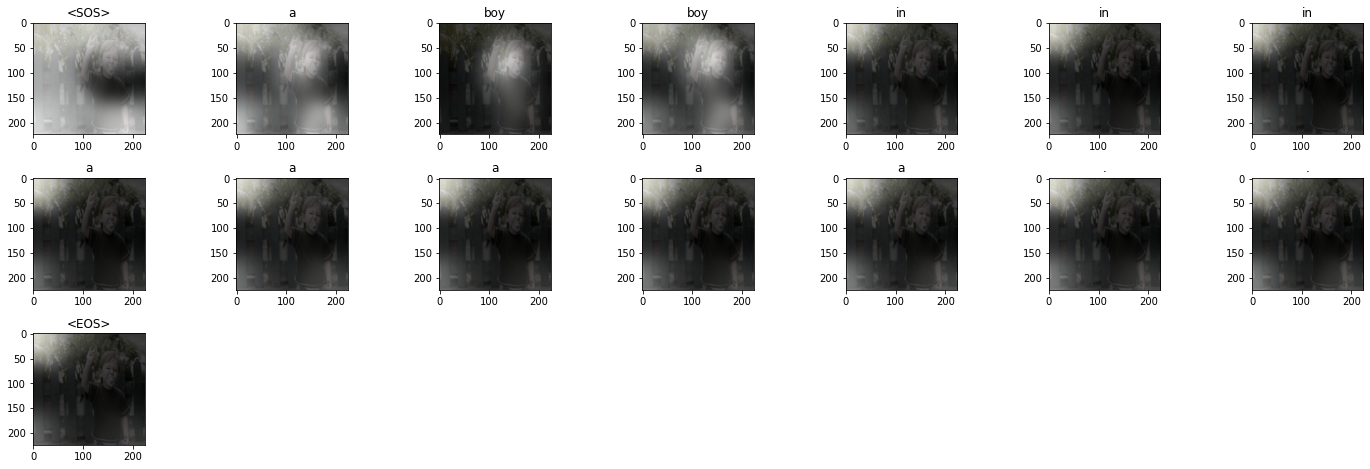

=> Saving checkpoint
3/100 - 0/569 |  Loss train-val = 3.3760 - 3.6424 | Acc train - val = 0.2511 - 0.2253


In [ ]:
train(200)